In [1]:
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm 

class_to_new_id = {
    'General trash': 0,
    'Paper': 1,
    'Paper pack': 2,
    'Metal': 3,
    'Glass': 4,
    'Plastic': 5,
    'Styrofoam': 6,
    'Plastic bag': 7,
    'Battery': 8,
    'Clothing': 9
}

In [24]:
# object detection csv 파일
original_df = pd.read_csv("/home/hwang/leem/level2-objectdetection-cv-18/2-stages/classification/csv/755.csv")
original_df.head()

,PredictionString,image_id
0,7 0.9999158382415771 217.27728271484375 51.463...,test/0000.jpg
1,5 0.9950434565544128 131.72872924804688 0.6714...,test/0001.jpg
2,1 0.9912028908729553 293.5939025878906 316.967...,test/0002.jpg
3,9 0.997534453868866 146.4696044921875 262.8951...,test/0003.jpg
4,1 0.8781476616859436 204.8412322998047 257.243...,test/0004.jpg


In [25]:
# tool

# PredictionString을 6개 단위로 나누는 함수 정의
def split_prediction_string(prediction_string):
    # 공백으로 나누어 리스트로 변환
    split_values = prediction_string.split()
    
    # 6개 단위로 묶어서 반환 (class_id, confidence_score, x1, y1, width, height)
    return [split_values[i:i+6] for i in range(0, len(split_values), 6)]

def save_cropimage_testinfocsv(image_id, bbox_info_list, savecrop):

    image_path = os.path.join("/hdd1/lim_data/level2_dataset", image_id)  # 'your_image_folder'에 실제 이미지가 위치
    img = Image.open(image_path)  # 이미지 로드
    test_info_data = []
    output_dir = '/hdd1/lim_data/level2_dataset/crop_test'

    # 각 bounding box에 대해 크롭 후 저장
    for idx, bbox_info in enumerate(bbox_info_list):
        class_id, confidence, x1, y1, width, height = map(float, bbox_info)
        x1, y1, width, height = int(x1), int(y1), int(width), int(height)

        if savecrop == True:
            # Bounding box로 이미지 크롭
            cropped_img = img.crop((x1, y1, width, height))

            # 크롭된 이미지 저장 (파일 이름에 image_id와 bbox 번호 포함)
            cropped_img_name = f"{os.path.splitext(os.path.basename(image_id))[0]}_crop_{idx}.jpg"
            cropped_img_path = os.path.join(output_dir, cropped_img_name)
            cropped_img.save(cropped_img_path)

        # cropped_img_name = f"{os.path.splitext(os.path.basename(image_id))[0]}_crop_{idx}.jpg"
        test_info_data.append({
            'label': int(class_id),  # label에 class_id를 임시로 저장
            'image_path': f"crop_test/{cropped_img_name}",
            'label_id': int(class_id),
            'cs' : confidence
        })

    return test_info_data


def save_detection_split_csv(df, output_csv_path):
    # CSV에 저장할 데이터를 담을 리스트
    split_data = []
    
    # 각 row에 대해 bbox 정보를 저장
    for index, row in tqdm(df.iterrows(), total=len(df)):
        image_id = row['image_id']
        bbox_info_list = row['bbox_info']

        for idx, bbox_info in enumerate(bbox_info_list):
            class_id, confidence, x1, y1, width, height = map(float, bbox_info)

            split_data.append({
                'image_id': os.path.basename(image_id),  # image_id의 base 경로만 저장
                'idx' : idx,
                'class_id': int(class_id),
                'confidence': confidence,
                'x1': x1,
                'y1': y1,
                'width': width,
                'height': height
            })

    # DataFrame으로 변환 후 CSV로 저장
    split_df = pd.DataFrame(split_data)
    split_df.to_csv(output_csv_path, index=False)

    return split_df

def convert_to_prediction_string_format(cropped_df, output_csv_path):
    # 새로 변환할 데이터를 담을 리스트
    prediction_data = []
    
    # image_id를 기준으로 그룹화하여 PredictionString을 생성
    grouped = cropped_df.groupby('image_id')
    
    for image_id, group in grouped:
        # 각 이미지에 대한 bbox 정보들을 PredictionString으로 결합
        prediction_string = " ".join(
            group.apply(lambda row: f"{int(row['class_id'])} {row['confidence']} {int(row['x1'])} {int(row['y1'])} {int(row['width'])} {int(row['height'])}", axis=1)
        )
        
        prediction_data.append({
            'PredictionString': prediction_string,
            'image_id': image_id
            
        })
    
    # DataFrame으로 변환 후 CSV로 저장
    prediction_df = pd.DataFrame(prediction_data)
    prediction_df.to_csv(output_csv_path, index=False)

    return prediction_df

In [26]:
root_dir = "/hdd1/lim_data/level2_dataset/test" # test 데이터 경로

# image_id & bbox info split
detection_df = original_df.copy(deep=False)
detection_df['bbox_info'] = detection_df['PredictionString'].apply(split_prediction_string)
detection_df = detection_df[['image_id', 'bbox_info']]
detection_df

,image_id,bbox_info
0,test/0000.jpg,"[[7, 0.9999158382415771, 217.27728271484375, 5..."
1,test/0001.jpg,"[[5, 0.9950434565544128, 131.72872924804688, 0..."
2,test/0002.jpg,"[[1, 0.9912028908729553, 293.5939025878906, 31..."
3,test/0003.jpg,"[[9, 0.997534453868866, 146.4696044921875, 262..."
4,test/0004.jpg,"[[1, 0.8781476616859436, 204.8412322998047, 25..."
...,...,...
4866,test/4866.jpg,"[[0, 0.9478341341018677, 294.16839599609375, 3..."
4867,test/4867.jpg,"[[3, 0.9999282956123352, 416.4012756347656, 32..."
4868,test/4868.jpg,"[[7, 0.9974269270896912, 113.00054168701172, 4..."
4869,test/4869.jpg,"[[0, 0.9752671122550964, 20.535079956054688, 2..."


In [27]:
output_csv_path = "/home/hwang/leem/level2-objectdetection-cv-18/2-stages/classification/csv/755_split.csv"
split_df = save_detection_split_csv(detection_df, output_csv_path)
split_df


100%|██████████| 4871/4871 [00:02<00:00, 1675.18it/s]


,image_id,idx,class_id,confidence,x1,y1,width,height
0,0000.jpg,0,7,0.999916,217.277283,51.463493,454.745697,472.634430
1,0000.jpg,1,7,0.999914,118.831833,422.222443,331.333771,716.075256
2,0000.jpg,2,7,0.999913,603.285645,518.557434,956.620728,1023.559143
3,0000.jpg,3,7,0.999606,390.877655,191.901199,601.309570,545.662598
4,0000.jpg,4,7,0.999341,449.855133,599.550110,647.170471,874.706055
...,...,...,...,...,...,...,...,...
1485207,4870.jpg,350,0,0.001149,588.638855,559.314880,638.991150,675.615356
1485208,4870.jpg,351,7,0.001147,424.845123,203.283051,489.231445,225.563766
1485209,4870.jpg,352,7,0.001146,379.330017,987.636047,521.705383,1023.473206
1485210,4870.jpg,353,3,0.001145,164.136505,224.134567,189.840332,235.793655


In [15]:
# test image crop & save , return test_info_csv
test_info_data = []  

for index, row in tqdm(detection_df.iterrows(), total=len(detection_df)):
    test_info_csv = save_cropimage_testinfocsv(row['image_id'], row['bbox_info'], savecrop=True)
    test_info_data.extend(test_info_csv)

test_info_df = pd.DataFrame(test_info_data)
test_info_df

100%|██████████| 4870/4870 [01:47<00:00, 45.16it/s]


,label,image_path,label_id,cs
0,7,crop_test/0000_crop_0.jpg,7,0.053629
1,5,crop_test/0000_crop_1.jpg,5,0.056447
2,5,crop_test/0000_crop_2.jpg,5,0.061287
3,1,crop_test/0000_crop_3.jpg,1,0.071180
4,0,crop_test/0000_crop_4.jpg,0,0.079329
...,...,...,...,...
38106,1,crop_test/4869_crop_19.jpg,1,0.789069
38107,0,crop_test/4869_crop_20.jpg,0,0.807574
38108,0,crop_test/4870_crop_0.jpg,0,0.206175
38109,1,crop_test/4870_crop_1.jpg,1,0.207481


In [16]:
# class_id를 label로 변환 및 저장 (classification 모델 input info)
test_info_df['label'] = test_info_df['label'].replace({v: k for k, v in class_to_new_id.items()})

save_name = "/home/hwang/leem/level2-objectdetection-cv-18/2-stages/classification/csv/yolo_test.csv"
test_info_df.to_csv(save_name, index=False)
test_info_df

,label,image_path,label_id,cs
0,Plastic bag,crop_test/0000_crop_0.jpg,7,0.053629
1,Plastic,crop_test/0000_crop_1.jpg,5,0.056447
2,Plastic,crop_test/0000_crop_2.jpg,5,0.061287
3,Paper,crop_test/0000_crop_3.jpg,1,0.071180
4,General trash,crop_test/0000_crop_4.jpg,0,0.079329
...,...,...,...,...
38106,Paper,crop_test/4869_crop_19.jpg,1,0.789069
38107,General trash,crop_test/4869_crop_20.jpg,0,0.807574
38108,General trash,crop_test/4870_crop_0.jpg,0,0.206175
38109,Paper,crop_test/4870_crop_1.jpg,1,0.207481


In [17]:
# classification prediction 으로 치환

# 1. 100% classification
    # return classification_df
# 2. confidence score를 고려해서 치환 (ex. detection 모델에선 낮은데 classification에선 높은것)
classification_df = pd.read_csv("/home/hwang/leem/level2-objectdetection-cv-18/2-stages/classification/csv/100_classification_yolo.csv")
classification_df

,label,image_path,label_id,cs
0,Plastic bag,crop_test/0000_crop_0.jpg,7,0.991104
1,Plastic bag,crop_test/0000_crop_1.jpg,7,0.681735
2,Paper,crop_test/0000_crop_2.jpg,1,0.692980
3,Paper,crop_test/0000_crop_3.jpg,1,0.967198
4,General trash,crop_test/0000_crop_4.jpg,0,0.693650
...,...,...,...,...
38106,Plastic bag,crop_test/4869_crop_19.jpg,7,0.634063
38107,General trash,crop_test/4869_crop_20.jpg,0,0.999663
38108,General trash,crop_test/4870_crop_0.jpg,0,0.892035
38109,Glass,crop_test/4870_crop_1.jpg,4,0.946917


In [18]:
test_info_df

,label,image_path,label_id,cs
0,Plastic bag,crop_test/0000_crop_0.jpg,7,0.053629
1,Plastic,crop_test/0000_crop_1.jpg,5,0.056447
2,Plastic,crop_test/0000_crop_2.jpg,5,0.061287
3,Paper,crop_test/0000_crop_3.jpg,1,0.071180
4,General trash,crop_test/0000_crop_4.jpg,0,0.079329
...,...,...,...,...
38106,Paper,crop_test/4869_crop_19.jpg,1,0.789069
38107,General trash,crop_test/4869_crop_20.jpg,0,0.807574
38108,General trash,crop_test/4870_crop_0.jpg,0,0.206175
38109,Paper,crop_test/4870_crop_1.jpg,1,0.207481


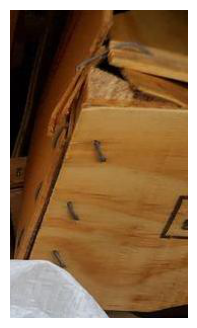

In [19]:
import matplotlib.pyplot as plt

image_path = "/hdd1/lim_data/level2_dataset/crop_test"
image_path = os.path.join(image_path, "4869_crop_19.jpg")

image = Image.open(image_path)
    
plt.figure(figsize=(4, 4))  # 시각화 크기 설정
plt.imshow(image)
plt.axis('off')  # 축 숨기기
plt.show()


In [20]:
split_df['class_id'] = classification_df['label_id']
# split_df['confidence'] = split_df['confidence']+classification_df['cs']
split_df['image_id'] = split_df['image_id'].apply(lambda x: f'test/{x}')
split_df

,image_id,idx,class_id,confidence,x1,y1,width,height
0,test/0000.jpg,0,7,0.053629,264.0,440.0,440.0,607.0
1,test/0000.jpg,1,7,0.056447,348.0,594.0,467.0,719.0
2,test/0000.jpg,2,1,0.061287,465.0,579.0,559.0,639.0
3,test/0000.jpg,3,1,0.071180,673.0,257.0,728.0,315.0
4,test/0000.jpg,4,0,0.079329,319.0,716.0,332.0,744.0
...,...,...,...,...,...,...,...,...
38106,test/4869.jpg,19,7,0.789069,849.0,2.0,1024.0,306.0
38107,test/4869.jpg,20,0,0.807574,0.0,233.0,1006.0,954.0
38108,test/4870.jpg,0,0,0.206175,240.0,822.0,290.0,854.0
38109,test/4870.jpg,1,4,0.207481,0.0,0.0,691.0,941.0


In [21]:
# original form 으로 변환
output_csv_path = "/home/hwang/leem/level2-objectdetection-cv-18/2-stages/classification/csv/100_yolo.csv"

# 분리된 데이터를 다시 PredictionString 형식으로 변환
prediction_df = convert_to_prediction_string_format(split_df, output_csv_path)

# 변환된 데이터 확인
prediction_df

,PredictionString,image_id
0,7 0.053629372268915176 264 440 440 607 7 0.056...,test/0000.jpg
1,0 0.09204626828432083 629 649 686 881 5 0.9021...,test/0001.jpg
2,1 0.05520516633987427 751 317 1024 915 1 0.067...,test/0002.jpg
3,9 0.06629489362239838 2 18 417 1019 9 0.098404...,test/0003.jpg
4,0 0.06048927456140518 426 508 473 577 1 0.5608...,test/0004.jpg
...,...,...
4865,1 0.068342424929142 288 349 668 692 1 0.595239...,test/4866.jpg
4866,0 0.08070029318332672 632 672 774 720 0 0.2345...,test/4867.jpg
4867,7 0.6249999403953552 545 535 678 767 7 0.90516...,test/4868.jpg
4868,0 0.057179421186447144 339 210 385 250 0 0.060...,test/4869.jpg


In [31]:
prediction_df = pd.read_csv("/home/hwang/leem/level2-objectdetection-cv-18/2-stages/classification/csv/co_dino_non_maximum_weighted_result.csv")

In [32]:
# PredictionString의 socre에 대해 정렬을 수행하는 함수
def sort_prediction_string(prediction_string):
    # 문자열을 숫자 리스트로 변환
    data = list(map(float, prediction_string.split()))
    
    # 6개의 요소마다 묶어 2D 리스트로 변환 (class_id, score, x_min, y_min, x_max, y_max)
    bbox_list = [data[i:i+6] for i in range(0, len(data), 6)]
    
    # 두 번째 요소(score)를 기준으로 내림차순 정렬
    sorted_bbox_list = sorted(bbox_list, key=lambda x: x[1], reverse=True)
    
    # 첫 번째 요소(class_id)는 int로, 나머지는 소수로 표현
    sorted_data = []
    for bbox in sorted_bbox_list:
        sorted_data.append(f"{int(bbox[0])} {' '.join(map(str, bbox[1:]))}")
    
    # 정렬된 PredictionString을 다시 문자열로 변환
    return " ".join(sorted_data)

# 각 행의 PredictionString에 함수 적용
prediction_df['PredictionString'] = prediction_df['PredictionString'].apply(sort_prediction_string)

# 결과를 새로운 CSV 파일로 저장
prediction_df.to_csv('sorted_dinoensemble.csv', index=False)

print("PredictionString 정렬 및 class_id 변환 완료!")

PredictionString 정렬 및 class_id 변환 완료!


In [23]:
# 일치 여부 확인

import pandas as pd

def compare_csv_format(file1_path, file2_path):
    # 두 CSV 파일 로드
    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)
    
    # 1. 컬럼 이름과 순서 비교
    columns_file1 = df1.columns.tolist()
    columns_file2 = df2.columns.tolist()
    
    if columns_file1 != columns_file2:
        print("❌ 두 CSV 파일의 컬럼 이름과 순서가 다릅니다.")
        print(f"파일 1의 컬럼: {columns_file1}")
        print(f"파일 2의 컬럼: {columns_file2}")
        return
    else:
        print("✅ 두 CSV 파일의 컬럼 이름과 순서가 동일합니다.")
    
    # 2. 행(row)과 열(column) 개수 비교
    if df1.shape != df2.shape:
        print(f"❌ 두 CSV 파일의 크기가 다릅니다. (파일 1: {df1.shape}, 파일 2: {df2.shape})")
        return
    else:
        print(f"✅ 두 CSV 파일의 크기(행과 열 개수)가 동일합니다. (크기: {df1.shape})")
    
    # 3. 첫 번째 열의 문자열 형식 비교 (공백 개수 확인)
    first_column_file1 = df1.iloc[:, 0].astype(str)
    first_column_file2 = df2.iloc[:, 0].astype(str)
    
    mismatch_count = 0
    
    for i in range(len(first_column_file1)):
        space_count_file1 = first_column_file1[i].count(' ')
        space_count_file2 = first_column_file2[i].count(' ')
        
        if space_count_file1 != space_count_file2:
            print(f"❌ 파일 1과 파일 2의 첫 번째 열에서 공백 개수가 다릅니다. (행 {i + 1})")
            print(f"파일 1: '{first_column_file1[i]}' (공백 {space_count_file1}개)")
            print(f"파일 2: '{first_column_file2[i]}' (공백 {space_count_file2}개)")
            mismatch_count += 1
            
    if mismatch_count == 0:
        print("✅ 첫 번째 열의 문자열 형식(공백 개수)이 두 파일에서 동일합니다.")
    else:
        print(f"총 {mismatch_count}개의 행에서 공백 개수가 다릅니다.")
    
# 사용 예시
# file1_path = "/home/hwang/leem/level2-objectdetection-cv-18/2-stages/classification/csv/100_WBF_ATSS.csv"
file1_path = '/home/hwang/leem/level2-objectdetection-cv-18/2-stages/classification/sorted_100_yolo.csv'
file2_path = "/home/hwang/leem/level2-objectdetection-cv-18/2-stages/level1-imageclassification-cv-18/post-processing/yolo_test.csv"
compare_csv_format(file1_path, file2_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/hwang/leem/level2-objectdetection-cv-18/2-stages/level1-imageclassification-cv-18/post-processing/yolo_test.csv'

In [28]:
test_info_df

,label,image_path,label_id,cs
0,Plastic bag,crop_test/0000_crop_0.jpg,7,0.053629
1,Plastic,crop_test/0000_crop_1.jpg,5,0.056447
2,Plastic,crop_test/0000_crop_2.jpg,5,0.061287
3,Paper,crop_test/0000_crop_3.jpg,1,0.071180
4,General trash,crop_test/0000_crop_4.jpg,0,0.079329
...,...,...,...,...
38106,Paper,crop_test/4869_crop_19.jpg,1,0.789069
38107,General trash,crop_test/4869_crop_20.jpg,0,0.807574
38108,General trash,crop_test/4870_crop_0.jpg,0,0.206175
38109,Paper,crop_test/4870_crop_1.jpg,1,0.207481


In [29]:
classification_df

,label,image_path,label_id,cs
0,Plastic bag,crop_test/0000_crop_0.jpg,7,0.991104
1,Plastic bag,crop_test/0000_crop_1.jpg,7,0.681735
2,Paper,crop_test/0000_crop_2.jpg,1,0.692980
3,Paper,crop_test/0000_crop_3.jpg,1,0.967198
4,General trash,crop_test/0000_crop_4.jpg,0,0.693650
...,...,...,...,...
38106,Plastic bag,crop_test/4869_crop_19.jpg,7,0.634063
38107,General trash,crop_test/4869_crop_20.jpg,0,0.999663
38108,General trash,crop_test/4870_crop_0.jpg,0,0.892035
38109,Glass,crop_test/4870_crop_1.jpg,4,0.946917


In [30]:
# 두 데이터프레임을 image_path를 기준으로 병합
df_merged = pd.merge(test_info_df[['image_path', 'label_id']], classification_df[['image_path', 'label_id']], on='image_path', suffixes=('_1', '_2'))

# label_id가 일치하는 경우와 불일치하는 경우를 계산
matching_count = (df_merged['label_id_1'] == df_merged['label_id_2']).sum()
non_matching_count = (df_merged['label_id_1'] != df_merged['label_id_2']).sum()

# 결과 출력
print(f"일치하는 label_id 수: {matching_count}")
print(f"불일치하는 label_id 수: {non_matching_count}")

일치하는 label_id 수: 22893
불일치하는 label_id 수: 15218


In [40]:
df_merged

,image_path,label_id_1,label_id_2
0,crop_test/0000_crop_0.jpg,7,7
1,crop_test/0000_crop_1.jpg,7,7
2,crop_test/0000_crop_2.jpg,1,1
3,crop_test/0000_crop_3.jpg,7,7
4,crop_test/0000_crop_4.jpg,7,7
...,...,...,...
298283,crop_test/4870_crop_17.jpg,0,4
298284,crop_test/4870_crop_18.jpg,4,4
298285,crop_test/4870_crop_19.jpg,3,4
298286,crop_test/4870_crop_20.jpg,7,6


In [41]:
matching_count + non_matching_count

298288